In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import os
import nltk

from functions import (
    TextPreprocessor,
    ModelTrainer,
    vectorize_text,
    resample_data,
    create_voting_classifier,
    plot_roc_curve,
    analyze_misclassifications,
    extract_ngrams,
    analyze_sentiment,
    calculate_sentiment_percentages,
)
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import classification_report
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from collections import Counter
from nltk.corpus import stopwords

# Descargar las stopwords en español (si no las tienes descargadas)
nltk.download('stopwords')

# Definir stopwords en español
stop_words = set(stopwords.words('spanish'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\eslab\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#### Cargar datos procesados

In [3]:
df = pd.read_csv("../data/fake_news_clean.csv")

#### Cargar y prepocesar datos

In [4]:
preprocessor = TextPreprocessor()
df = preprocessor.preprocess(df)
df.dropna(inplace=True)


In [5]:
# Separar características (X) y etiquetas (y)
X = df['Text']
y = df['Category']

In [6]:
# División de datos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### Vectorización del texto con TF-IDF y resampling para balancear clases
Intentar cargar vectorizador desde archivo, si no existe, entrenar y guardar

In [7]:
vectorizer_path = "tfidf_vectorizer.pkl"

try:
    with open(vectorizer_path, "rb") as f:
        vectorizer = pickle.load(f)
    print("Vectorizador cargado desde archivo.")
except FileNotFoundError:
    print("Archivo no encontrado. Creando un nuevo vectorizador.")
    vectorizer = TfidfVectorizer(max_features=5000)
    X_train_vec = vectorizer.fit_transform(X_train)  # Ajustar y transformar
    X_test_vec = vectorizer.transform(X_test)  # Transformar conjunto de prueba
    with open(vectorizer_path, "wb") as f:
        pickle.dump(vectorizer, f)
    print("Vectorizador entrenado y guardado en archivo.")

Vectorizador cargado desde archivo.


In [14]:
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 3), stop_words=list(stop_words))

In [15]:
# Transformar los textos de entrenamiento y prueba
X_train_vec = vectorizer.fit_transform(X_train)  # Vectorizamos los textos de entrenamiento
X_test_vec = vectorizer.transform(X_test)        # Vectorizamos los textos de prueba

In [16]:
# Resampling para balancear clases después de la vectorización
X_train_resampled, y_train_resampled = resample_data(X_train_vec, y_train, method='SMOTE')

#### Reducción de dimensionalidad con TruncatedSVD
Intentar cargar modelo SVD desde archivo, si no existe, entrenar y guardar

In [17]:
svd_path = 'svd_model.pkl'

# Verificar si el modelo SVD ya está guardado
if os.path.exists(svd_path):
    try:
        with open(svd_path, "rb") as f:
            svd = pickle.load(f)
    except Exception as e:
        print(f"Error cargando el modelo SVD: {e}")
else:
    svd = TruncatedSVD(n_components=100, random_state=42)
    X_train_svd_resampled = svd.fit_transform(X_train_resampled)
    X_test_svd = svd.transform(X_test_vec)

    # Guardar el modelo SVD
    with open(svd_path, "wb") as f:
        pickle.dump(svd, f)

#### Entrenamiento de diferentes modelos con Machine Learning
Intentar cargar los modelos entrenados desde archivo, si no existen, entrenar y guardar


In [18]:
trainer = ModelTrainer()
model_paths = {
    "Logistic Regression": "logreg_model.pkl",
    "Random Forest": "rf_model.pkl",
    "SVM": "svm_model.pkl",
    "XGBoost": "xgb_model.pkl"
}
predictions_smote = {}
probabilities_smote = {}

for model_name, model_path in model_paths.items():
    try:
        with open(model_path, "rb") as f:
            trainer.classifiers[model_name] = pickle.load(f)
        print(f"{model_name} cargado desde archivo.")
    except FileNotFoundError:
        print(f"Entrenando {model_name}...")
        trainer.classifiers[model_name].fit(X_train_svd_resampled, y_train_resampled)
        with open(model_path, "wb") as f:
            pickle.dump(trainer.classifiers[model_name], f)
        print(f"{model_name} entrenado y guardado en archivo.")


Entrenando Logistic Regression...
Logistic Regression entrenado y guardado en archivo.
Entrenando Random Forest...
Random Forest entrenado y guardado en archivo.
Entrenando SVM...
SVM entrenado y guardado en archivo.
Entrenando XGBoost...
XGBoost entrenado y guardado en archivo.


In [19]:
# Predecir y calcular probabilidades
for model_name in model_paths.keys():
    predictions_smote[model_name] = trainer.classifiers[model_name].predict(X_test_svd)
    probabilities_smote[model_name] = trainer.classifiers[model_name].predict_proba(X_test_svd)[:, 1]


Logistic Regression Report:
              precision    recall  f1-score   support

           0       0.71      0.68      0.69       333
           1       0.69      0.73      0.71       332

    accuracy                           0.70       665
   macro avg       0.70      0.70      0.70       665
weighted avg       0.70      0.70      0.70       665



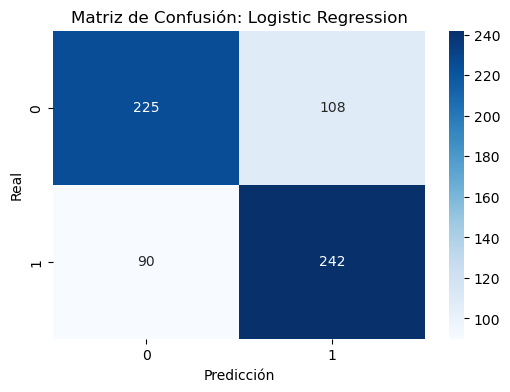


Random Forest Report:
              precision    recall  f1-score   support

           0       0.75      0.73      0.74       333
           1       0.73      0.75      0.74       332

    accuracy                           0.74       665
   macro avg       0.74      0.74      0.74       665
weighted avg       0.74      0.74      0.74       665



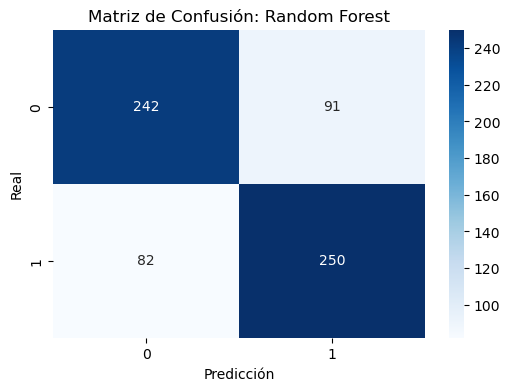


SVM Report:
              precision    recall  f1-score   support

           0       0.74      0.69      0.71       333
           1       0.71      0.75      0.73       332

    accuracy                           0.72       665
   macro avg       0.72      0.72      0.72       665
weighted avg       0.72      0.72      0.72       665



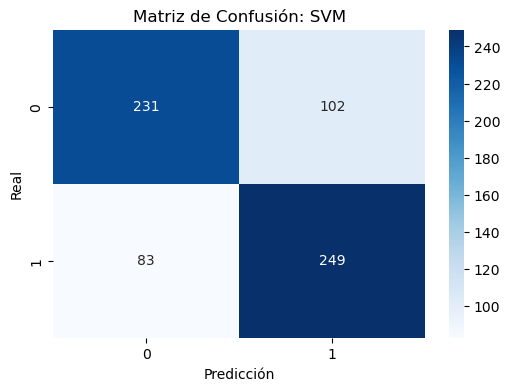


XGBoost Report:
              precision    recall  f1-score   support

           0       0.76      0.75      0.76       333
           1       0.75      0.77      0.76       332

    accuracy                           0.76       665
   macro avg       0.76      0.76      0.76       665
weighted avg       0.76      0.76      0.76       665



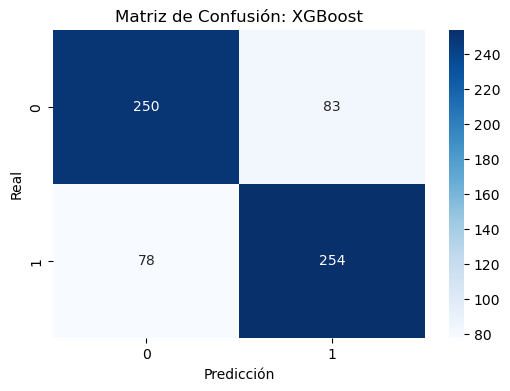

In [20]:
# Evaluación de modelos
results_smote = trainer.evaluate_models(predictions_smote, y_test)

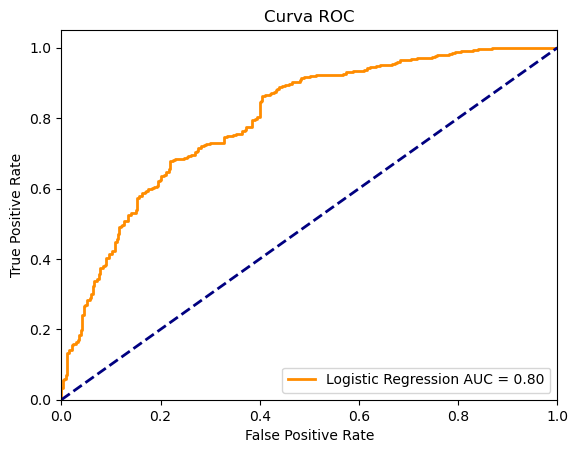

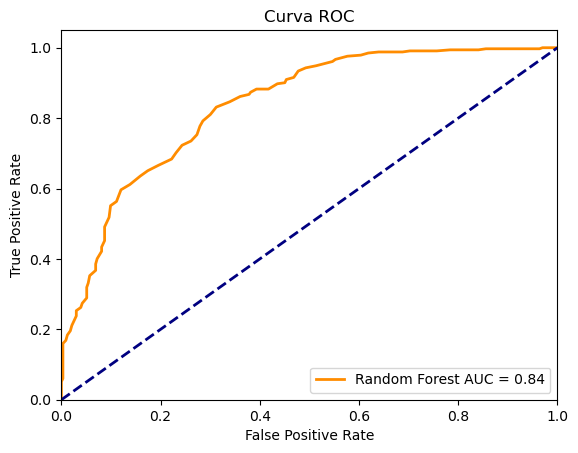

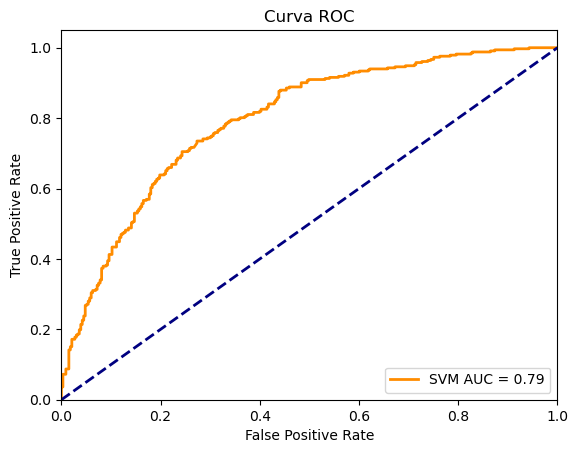

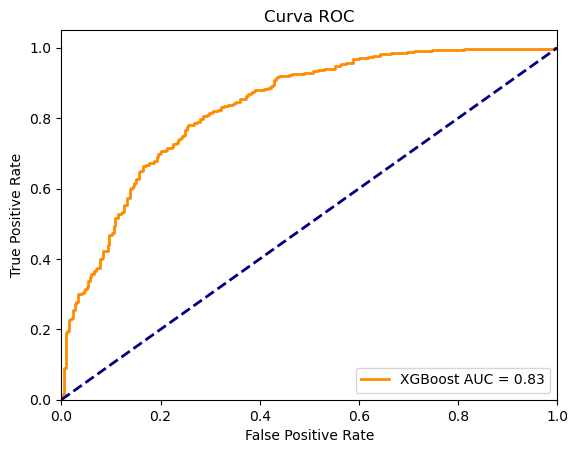

In [21]:
# Graficar la curva ROC para cada modelo
for model_name, y_scores in probabilities_smote.items():
    plot_roc_curve(y_test, y_scores, model_name)

####  Creación y evaluación de  Voting Classifier

In [22]:
voting_classifier_path = "voting_classifier.pkl"
try:
    with open(voting_classifier_path, "rb") as f:
        voting_classifier = pickle.load(f)
    print("Voting Classifier cargado desde archivo.")
except FileNotFoundError:
    voting_classifier = create_voting_classifier([
        ("logreg", trainer.classifiers["Logistic Regression"]),
        ("rf", trainer.classifiers["Random Forest"]),
        ("xgb", trainer.classifiers["XGBoost"]),
        ("svm", trainer.classifiers["SVM"])
    ])
    voting_classifier.fit(X_train_svd_resampled, y_train_resampled)
    with open(voting_classifier_path, "wb") as f:
        pickle.dump(voting_classifier, f)
    print("Voting Classifier entrenado y guardado en archivo.")


Voting Classifier entrenado y guardado en archivo.


In [23]:
# Evaluar Voting Classifier
y_pred_voting = voting_classifier.predict(X_test_svd)
print("Informe de clasificación del Voting Ensemble:")
print(classification_report(y_test, y_pred_voting, zero_division=0))

Informe de clasificación del Voting Ensemble:
              precision    recall  f1-score   support

           0       0.77      0.73      0.75       333
           1       0.74      0.78      0.76       332

    accuracy                           0.75       665
   macro avg       0.75      0.75      0.75       665
weighted avg       0.75      0.75      0.75       665



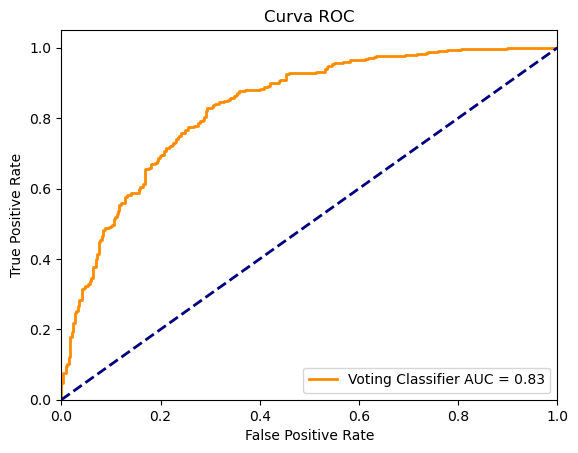

In [24]:
# Graficar la curva ROC para Voting Classifier
y_scores_voting = voting_classifier.predict_proba(X_test_svd)[:, 1]
plot_roc_curve(y_test, y_scores_voting, "Voting Classifier")

#### Análisis de clasificaciones erróneas

In [25]:
# Analizar clasificaciones erróneas para cada modelo con manejo de errores
models = ["Random Forest", "Logistic Regression", "SVM", "XGBoost"]
for model in models:
    preds = predictions_smote.get(model)
    if preds is not None:
        misclassified = analyze_misclassifications(X_test, y_test, preds, model)
    else:
        print(f"No se encontraron predicciones para {model}.")


Ejemplos mal clasificados para Random Forest:
                                                   Text  Actual  Predicted
809   piojo herrera descartar llegada chicharito amé...       1          0
2836  tuitsasegura presidente ser localizar playa la...       0          1
332   municipio hacer parte top nivel país afectació...       0          1
1822  consultora loren realizar primero prueba pilot...       1          0
299   primero acto laboratorio pfizer ofrecer méxico...       0          1
1251  automóvil funcionar cocacola revolucionar indu...       0          1
70    viernes cdc centro control prevención enfermed...       0          1
1071  propaganda yún orden captura esposa duarte aml...       1          0
30    semana punto ciudad registrar manifestación at...       1          0
194   pensábamos él medio oficial negar vez converti...       0          1

Ejemplos mal clasificados para Logistic Regression:
                                                   Text  Actual  Predicted


In [26]:
# Verifica las claves en el diccionario de predicciones
print("Claves en predictions_smote:", predictions_smote.keys())

Claves en predictions_smote: dict_keys(['Logistic Regression', 'Random Forest', 'SVM', 'XGBoost'])


In [27]:
misclassified_rf = analyze_misclassifications(
    X_test, y_test, predictions_smote["Random Forest"], "Random Forest"
)
misclassified_logreg = analyze_misclassifications(
    X_test, y_test, predictions_smote["Logistic Regression"], "Logistic Regression"
)
misclassified_svm = analyze_misclassifications(
    X_test, y_test, predictions_smote["SVM"], "SVM"
)
misclassified_xgb = analyze_misclassifications(
    X_test, y_test, predictions_smote["XGBoost"], "XGBoost"
)


Ejemplos mal clasificados para Random Forest:
                                                   Text  Actual  Predicted
809   piojo herrera descartar llegada chicharito amé...       1          0
2836  tuitsasegura presidente ser localizar playa la...       0          1
332   municipio hacer parte top nivel país afectació...       0          1
1822  consultora loren realizar primero prueba pilot...       1          0
299   primero acto laboratorio pfizer ofrecer méxico...       0          1
1251  automóvil funcionar cocacola revolucionar indu...       0          1
70    viernes cdc centro control prevención enfermed...       0          1
1071  propaganda yún orden captura esposa duarte aml...       1          0
30    semana punto ciudad registrar manifestación at...       1          0
194   pensábamos él medio oficial negar vez converti...       0          1

Ejemplos mal clasificados para Logistic Regression:
                                                   Text  Actual  Predicted


#### Función para realizar análisis de bigramas, nube de palabras y análisis de sentimiento en los modelos

Bigrams más comunes en Random Forest: [(('red', 'social'), 30), (('poder', 'ser'), 22), (('medio', 'comunicación'), 20), (('lópez', 'obrador'), 18), (('ciudad', 'méxico'), 17), (('deber', 'ser'), 14), (('tres', 'día'), 14), (('papa', 'francisco'), 13), (('number', 'año'), 12), (('hacer', 'él'), 12)]


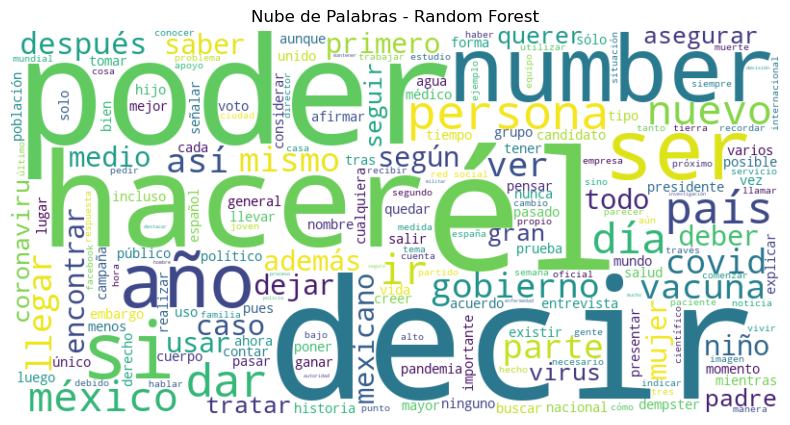


Porcentajes de Polaridad para Random Forest:
Positivo: 39.88%
Negativo: 15.61%
Neutro: 44.51%
Bigrams más comunes en Logistic Regression: [(('red', 'social'), 45), (('lópez', 'obrador'), 28), (('poder', 'ser'), 24), (('medio', 'comunicación'), 16), (('efecto', 'secundario'), 15), (('tres', 'día'), 15), (('deber', 'ser'), 14), (('andrés', 'manuel'), 13), (('number', 'año'), 13), (('ciudad', 'méxico'), 13)]


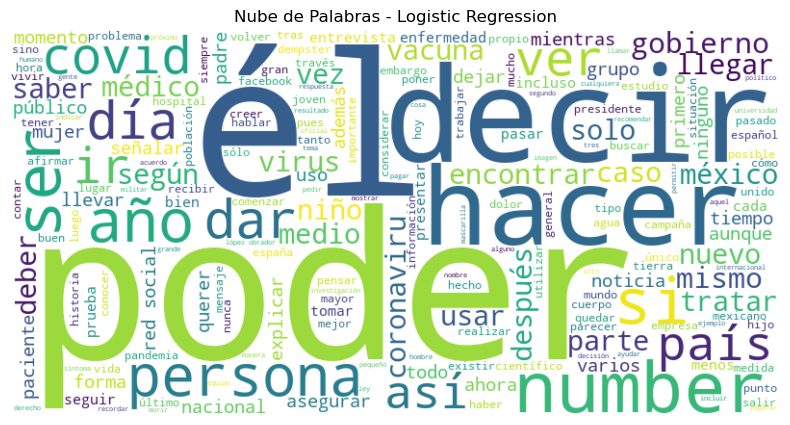


Porcentajes de Polaridad para Logistic Regression:
Positivo: 37.37%
Negativo: 13.64%
Neutro: 48.99%
Bigrams más comunes en SVM: [(('red', 'social'), 44), (('lópez', 'obrador'), 27), (('poder', 'ser'), 23), (('efecto', 'secundario'), 15), (('tres', 'día'), 15), (('medio', 'comunicación'), 14), (('andrés', 'manuel'), 13), (('deber', 'ser'), 13), (('number', 'año'), 12), (('ciudad', 'méxico'), 12)]


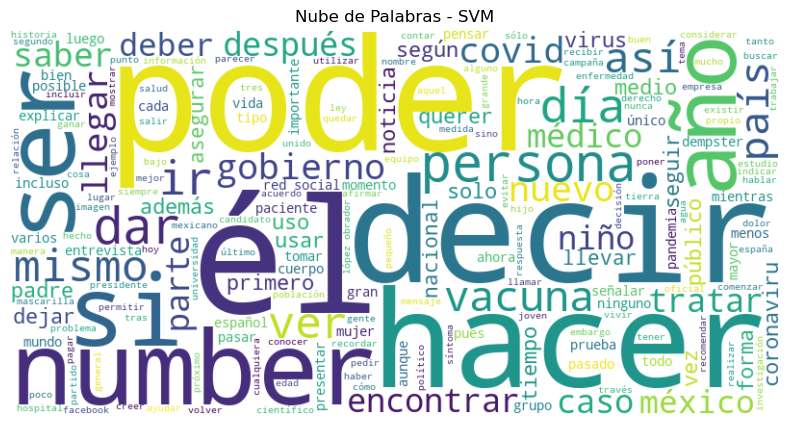


Porcentajes de Polaridad para SVM:
Positivo: 37.84%
Negativo: 12.43%
Neutro: 49.73%
Bigrams más comunes en XGBoost: [(('red', 'social'), 27), (('poder', 'ser'), 21), (('lópez', 'obrador'), 20), (('medio', 'comunicación'), 18), (('number', 'año'), 16), (('number', 'number'), 16), (('efecto', 'secundario'), 15), (('deber', 'ser'), 14), (('hacer', 'él'), 14), (('tres', 'día'), 14)]


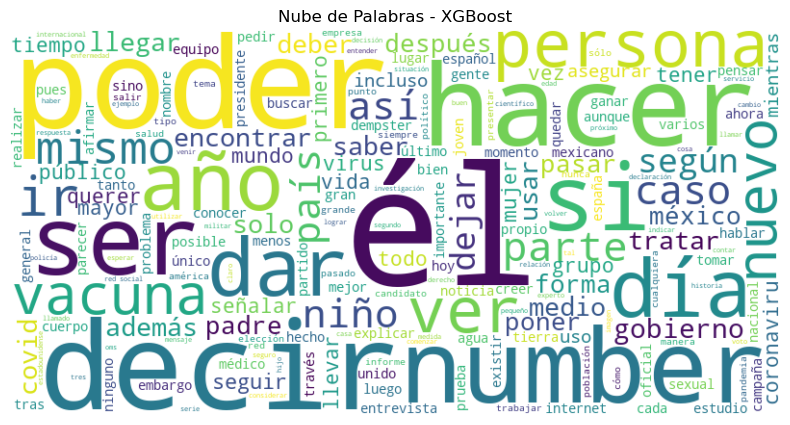


Porcentajes de Polaridad para XGBoost:
Positivo: 36.02%
Negativo: 14.91%
Neutro: 49.07%


In [32]:
def analyze_model_performance(df_misclassified, model_name):
    # Análisis de bigramas
    texts = df_misclassified["Text"].tolist()
    bigrams = extract_ngrams(texts, 2)
    bigram_counts = Counter(bigrams)
    print(f"Bigrams más comunes en {model_name}:", bigram_counts.most_common(10))
    # Nube de palabras
    all_texts = " ".join(texts)
    wordcloud = WordCloud(width=800, height=400, background_color="white").generate(
        all_texts
    )
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Nube de Palabras - {model_name}")
    plt.show()

    # Análisis de sentimiento
    sentiment_results = analyze_sentiment(texts)
    percentages = calculate_sentiment_percentages(sentiment_results)

    print(f"\nPorcentajes de Polaridad para {model_name}:")
    print(f"Positivo: {percentages['positive']:.2f}%")
    print(f"Negativo: {percentages['negative']:.2f}%")
    print(f"Neutro: {percentages['neutral']:.2f}%")


# Análisis de los modelos
analyze_model_performance(misclassified_rf, "Random Forest")
analyze_model_performance(misclassified_logreg, "Logistic Regression")
analyze_model_performance(misclassified_svm, "SVM")
analyze_model_performance(misclassified_xgb, "XGBoost")